In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
import time
import tensorflow_datasets as tfds
import models
import metrics
import losses
import utils
import Data_pipline
import pandas as pd

In [10]:
utils.set_seed_globally()

In [11]:
def random_rotate(img):
    img = img.numpy()
    x = tf.keras.preprocessing.image.random_rotation(img,90,channel_axis=2)
    return tf.convert_to_tensor(x)

def random_shift(img):
    img = img.numpy()
    x = tf.keras.preprocessing.image.random_shift(img,0.3,0.3,channel_axis=2)
    return tf.convert_to_tensor(x)

def random_zoom(img):
    img = img.numpy()
    x = tf.keras.preprocessing.image.random_zoom(img,[0.3,0.8],channel_axis=2)
    return tf.convert_to_tensor(x)

In [14]:
class training:
    def __init__(self,model,loss_function,train_data,train_dataset_size,optimizer,save_dir = os.path.join(".."),
                 epochs=100,batch_size=32,test_data=None,test_dataset_size=None,metric_list=["acc"],
                 augmentation=False,augmentation_steps=None,augmentation_list=[],data_when_no_agumentation_original=True,
                 shffule=True,shffule_steps=1,shffule_buffer_size=1000):
        self.model = model
        self.loss_function = "categorical_crossentropy"
        self.metric_list = metric_list
        self.train_data = train_data
        self.optimizer = optimizer
        self.train_dataset_size = train_dataset_size
        self.test_dataset_size = test_dataset_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_data = test_data
        self.augmentation = augmentation
        self.augmentation_steps = augmentation_steps
        self.augmentation_list = augmentation_list
        self.data_when_no_agumentation_original = data_when_no_agumentation_original 
        self.shffule = shffule
        self.shffule_buffer_size = shffule_buffer_size
        self.shffule_steps = shffule_steps
        self.metric_mapping_dic = {"acc":metrics.supervised_acc}
        self.losses_mapping_dic = {"categorical_crossentropy":losses.categorical_crossentropy}
        self.shffule_buffer_size = shffule_buffer_size
        self.save_dir = save_dir
        self.trained_model = self.train()
        
        
    def metrics_calc_logging(self,y_true,y_pred,epoch,batch,loss,train=True,epoch_end=False):
        
        if train:
            
            if epoch_end:
                self.metric_log_train["loss"].append(np.mean(self.metric_batch_log_train["loss"]))
                self.metric_log_train["epoch"].append(epoch)
                print("\n========> loss : %.4f"%self.metric_log_train["loss"][epoch-1],end=" ")
                self.metric_batch_log_train["loss"] = []
                
                for i in range(len(self.metric_list)):
                    self.metric_log_train[self.metric_list[i]].append(np.mean(self.metric_batch_log_train[self.metric_list[i]]))
                    self.metric_batch_log_train[self.metric_list[i]]=[]
                    print(self.metric_list[i],": ","%.4f"%(self.metric_log_train[self.metric_list[i]][epoch-1]),end=" ")
                print("\n")
                return 
            
            if epoch==1 and batch==1:
                
                self.metric_batch_log_train = {"loss":[]}
                self.metric_log_train = {"epoch":[],"loss":[]}
                for i in range(len(self.metric_list)):
                    self.metric_batch_log_train[self.metric_list[i]]=[]
                    self.metric_log_train[self.metric_list[i]] = []
            
            loss = loss.numpy()        
            self.metric_batch_log_train["loss"].append(loss)
            for i in range(len(self.metric_list)):
                self.metric_batch_log_train[self.metric_list[i]].append(self.metric_mapping_dic[self.metric_list[i]](y_true,y_pred))
            
                
        else:
            if epoch_end:
                self.metric_log_test["loss"].append(np.mean(self.metric_batch_log_test["loss"]))
                self.metric_log_test["epoch"].append(epoch)
                print("\n========> loss : %.4f"%self.metric_log_test["loss"][epoch-1],end=" ")
                self.metric_batch_log_test["loss"] = []
                for i in range(len(self.metric_list)):
                    self.metric_log_test[self.metric_list[i]].append(np.mean(self.metric_batch_log_test[self.metric_list[i]]))
                    self.metric_batch_log_test[self.metric_list[i]]=[]
                    print(self.metric_list[i],": ","%.4f"%(self.metric_log_test[self.metric_list[i]][epoch-1]),end=" ")
                print("\n")
                return 
            
            if epoch==1 and batch==1:
                
                self.metric_batch_log_test = {"loss":[]}
                self.metric_log_test = {"epoch":[],"loss":[]}
                for i in range(len(self.metric_list)):
                    self.metric_batch_log_test[self.metric_list[i]]=[]
                    self.metric_log_test[self.metric_list[i]] = []
            
            loss = loss.numpy()        
            self.metric_batch_log_test["loss"].append(loss)
            for i in range(len(self.metric_list)):
                self.metric_batch_log_test[self.metric_list[i]].append(self.metric_mapping_dic[self.metric_list[i]](y_true,y_pred))
            
            
            
    
    @tf.function    
    def forward_backward_prop(self,img,label,training=True):
        with tf.GradientTape() as tape:
            y_pred = self.model(img,training=training)
            loss_value = self.losses_mapping_dic[self.loss_function](label,y_pred)
        if training:
            grads = tape.gradient(loss_value, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return y_pred,loss_value
    
    def data_agumentation_func(self,idx,y):
        if idx%self.aug_len == 0:
            lab = self.labels_list[int(tf.math.floor(idx/self.aug_len))]
            return y,lab
        else:
            y = self.augmentation_list[idx%self.aug_len-1](y)
            lab = self.labels_list[int(tf.math.floor(idx/self.aug_len))]
            return y,lab 
    
    def output_value(self,idx,y):
        if self.labels_required_for_output and not(self.images_required_for_output):
            return y
        elif self.images_required_for_output and not(self.labels_required_for_output):
            return y[0],y[0]
        elif self.images_required_for_output and self.labels_required_for_output:
            return y[0],y[0],y[1]
        elif not(self.labels_required_for_output) and not(self.images_required_for_output):
            return y[0]
        return y
        
    
    def train(self):
        
        train_data = self.train_data
        if self.test_data:
            test_data = self.test_data
        if self.augmentation:
            if len(self.augmentation_list)==0:
                raise ValueError("Data augmentation list is empty so no data augmentation is applied")
            self.aug_len = len(self.augmentation_list)+1
            sample_data = list(train_data.take(1).as_numpy_iterator())
            self.len_sample = len(sample_data[0])
            if self.len_sample==2 and len(sample_data[0][1].shape)==0:
                self.labels_required_for_output = True
                self.images_required_for_output = False
            elif self.len_sample==2 and len(sample_data[0][1].shape)==3:
                self.labels_required_for_output = False
                self.images_required_for_output = True
            elif self.len_sample==3 and len(sample_data[0][2].shape)==0 and len(sample_data[0][1].shape)==3:
                self.labels_required_for_output = True
                self.images_required_for_output = True
            self.train_dataset_size_aug = int(self.train_dataset_size*self.aug_len)    
            self.labels_list = np.array(list(train_data.take(-1).as_numpy_iterator()),dtype=object)[:,1]
            labels_removed_data = train_data.enumerate().map(lambda idx,x:x[0],num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
            duplicates_created_data = labels_removed_data.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(self.aug_len),block_length=self.aug_len)
        if not self.augmentation:
            total_Train_batches = int(np.ceil(self.train_dataset_size/self.batch_size))
            
        
        for epoch in range(1,self.epochs+1):
            print("\nEpoch {} / {}".format(epoch,self.epochs))
            
            if self.augmentation:
                if epoch%self.augmentation_steps==0 or epoch==1:
                    print("Agumented the  Dataset")
                    augmented_data = duplicates_created_data.enumerate().map(lambda idx,x : tf.py_function(func = self.data_agumentation_func,inp=[idx,x],Tout=(tf.float32,tf.int32)),num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
                    augmented_data = augmented_data.enumerate().map(self.output_value,num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
                    train_data = augmented_data
                    total_Train_batches = int(np.ceil(self.train_dataset_size_aug/self.batch_size))
                else:
                    if self.data_when_no_agumentation_original: 
                        train_data = self.train_data
                        total_Train_batches = int(np.ceil(self.train_dataset_size/self.batch_size))
                    else:
                        train_data = augmented_data
                        total_Train_batches = int(np.ceil(self.train_dataset_size_aug/self.batch_size))
            else:
                train_data = self.train_data
                
            if self.shffule:
                if epoch%self.shffule_steps==0:
                    train_data = train_data.shuffle(self.shffule_buffer_size)
            train_data = train_data.batch(self.batch_size)
            train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)
            for batch,(img,label) in train_data.enumerate(1):
                print("====>Training Batch {} / {}".format(batch,total_Train_batches),end="\r")
                label = tf.one_hot(label,depth=10)
                y_pred,loss_value = self.forward_backward_prop(img,label)
                self.metrics_calc_logging(label,y_pred,epoch,batch,loss_value,train=True)
            self.metrics_calc_logging(None,None,epoch,batch,None,epoch_end=True,train=True)
            
            if self.test_data:
                total_test_batches = int(np.ceil(self.test_dataset_size/self.batch_size))
                test_data = self.test_data
                test_data = test_data.batch(self.batch_size)
                for batch,(img,label) in test_data.enumerate(1):
                    print("====>Test Batch {} / {}".format(batch,total_test_batches),end="\r")
                    label = tf.one_hot(label,depth=10)
                    y_pred,loss_value = self.forward_backward_prop(img,label,training=False)
                    self.metrics_calc_logging(label,y_pred,epoch,batch,loss_value,train=False)
                self.metrics_calc_logging(None,None,epoch,batch,None,epoch_end=True,train=False)
                
        
        df_train = pd.DataFrame.from_dict(self.metric_log_train)
        df_train.to_csv(os.path.join(self.save_dir,"train_log.csv"),index=False)
        if self.test_data:
            df_test = pd.DataFrame.from_dict(self.metric_log_test)
            df_test.to_csv(os.path.join(self.save_dir,"test_log.csv"),index=False)
        print("Saving the model,train log and test log in : ",self.save_dir,"============>")
        
        self.model.save(os.path.join(self.save_dir,"classifer.h5"))
        return self.model      

In [15]:
class experiments:
    def __init__(self,dataset_path=None,dataset=None,image_size=(32,32),Data_preprocessing="0",Augmentation="0",Shuffling="0",Regularization="0",Models="0",
                 classifier=True,augmentation_list = [],augmentation_steps=10,split=True,split_ratio=[0.8,0.2],batch_size=32,epochs=200,shuffling_steps=1,
                 save_train_test_data = False,dropout=0.5):
        self.dataset_path = dataset_path
        self.dataset = dataset
        self.image_size = image_size
        self.Data_preprocessing = Data_preprocessing
        self.Augmentation = Augmentation
        self.Shuffling = Shuffling
        self.Regularization = Regularization
        self.Models = Models
        self.classifier = classifier
        self.augmentation_list = augmentation_list
        self.augmentation_steps = augmentation_steps
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffling_steps = shuffling_steps
        self.split = split
        self.split_ratio = split_ratio
        self.dropout = dropout
        self.dataset_list = ["cifar10","fashion_mnist","mnist"]
        self.save_train_test_data  = save_train_test_data 
        if self.dataset:
            self.image_size = (None,None)
        self.save_dir = self.decide_saving_dir()
        
        """ 
        0: No Normalization,
        1: Normalization [0,1], 
        2: Per Pixel Standardization 
        setting the dataset.image_preprocessing parameter
        """
        self.data_preprocessing_dic = {"0":"0","1":"1","2":"2"}
        
        """
        0: No augmentation,
        1: augmentation before training, 
        2: augmentation after self.augmentation_steps epochs and using original data when epoch % self.augmentation_steps!=0
        3: augmentation after self.augmentation_steps epochs and using previously augmented data when epoch % self.augmentation_steps!=0
        setting the (dataset.augmentation,training.augmentation,training.data_when_no_agumentation_original) parameter
        """
        self.augmentation_dic = {"0":(False,False,False),"1":(True,False,False),"2":(False,True,True),"3":(False,True,False)}
        
        """
        0: No shuffling,
        1: shuffling after self.shuffling_steps epochs full dataset
        2: shuffling after self.shuffling_steps epochs among the batches
        setting the (training.shuffle,training.shffule_buffer_size)
        """
        self.train_dataset_size = None
        self.shuffling_dic = {"0":(False,None),"1":[True,self.train_dataset_size],"2":[True,self.batch_size]}
        
        """
        0: No regularization (neither batchnormalization nor dropout)
        1: Only batchnormalization
        2: Only dropout at convolutional layers with 0.5 dropout value
        3: Only dropout at dense layers with 0.5 dropout value
        4: Only dropout at both convolutional and denses layers with 0.5 dropout value
        5: Batch normalization + best of (2,3,4) droputs with 0.5 dropout value
        setting the parameters of the (models.if_batch_normalization,models.if_dropout_dense,models.if_dropout_conv)
        """
        self.regularization_dic = {"0":(False,False,False),"1":(True,False,False),"2":(False,False,True),
                                   "3":(False,True,False),"4":(False,True,True),5:(True,True,True)}
        
        """
        0: VGG
        Choosing the models from models.py file
        """
        self.models_classifier_dic = {"0":{"cifar10":models.Classifier_VGG_CIFAR10,"fashion_mnist":models.Classifier_VGG_MNIST,"mnist":models.Classifier_VGG_MNIST}}
                                   
    def decide_saving_dir(self):
        results_folder = os.path.join("..","results")
        if not os.path.exists(results_folder):
            os.mkdir(results_folder)
        if not self.dataset:
            dataset_name = str(input("===============>Enter the Name of the dataset : "))
        else:
            if self.dataset not in self.dataset_list:
                raise ValueError("Dataset ",self.dataset," not present in ",self.dataset_list," please choose among these")
            
            dataset_name = self.dataset
        
        result_dataset_folder = os.path.join(results_folder,dataset_name)
        
        if not os.path.exists(result_dataset_folder):
            os.mkdir(result_dataset_folder)
        additional_name = str(input("==============>enter any additional name if wanted else enter No : "))
        if additional_name == "No":
            
            saving_folder_name = os.path.join(result_dataset_folder,self.Data_preprocessing+"_"+self.Augmentation+"_"
                                          +self.Shuffling+"_"+self.Regularization+"_"+self.Models)
        else:
            saving_folder_name = os.path.join(result_dataset_folder,self.Data_preprocessing+"_"+self.Augmentation+"_"
                                          +self.Shuffling+"_"+self.Regularization+"_"+self.Models+"_"+additional_name)
            
        
        
        
        if not os.path.exists(saving_folder_name):
            os.mkdir(saving_folder_name)
            
        return saving_folder_name
    
    def __call__(self):
        if self.classifier:
            self.split = True
        
            dataset = Data_pipline.Data_Pipeline(
                                    dataset_path = self.dataset_path,
                                    dataset = self.dataset,
                                    image_size = self.image_size,
                                    image_preprocessing = self.Data_preprocessing,
                                    split = self.split,
                                    split_ratio = self.split_ratio,
                                    labels_required_for_output = self.classifier,
                                    images_required_for_output = False,
                                    save_data = self.save_train_test_data ,
                                    data_agumentation = self.augmentation_dic[self.Augmentation][0],
                                    data_agumentation_list = self.augmentation_list
                                    )
            
            model = self.models_classifier_dic[self.Models][self.dataset](
                        if_batch_normalization = self.regularization_dic[self.Regularization][0],
                        if_dropout_dense = self.regularization_dic[self.Regularization][1],
                        if_dropout_conv = self.regularization_dic[self.Regularization][2],
                        dropout_value = self.dropout
                
            )
            print(model.summary())

            self.train_dataset_size = dataset.train_dataset_size
            self.shuffling_dic["1"][1] = self.train_dataset_size
            self.shuffling_dic["2"][1] = self.batch_size
            model_trained = training(
                                     model = model,
                                     loss_function = "categorical_crossentropy",
                                     train_data = dataset.train_data,
                                     train_dataset_size = dataset.train_dataset_size,
                                     optimizer = tf.keras.optimizers.Adam(),
                                     save_dir = self.save_dir,
                                     epochs = self.epochs,
                                     batch_size = self.batch_size,
                                     test_data = dataset.test_data,
                                     metric_list = ["acc"],
                                     test_dataset_size = dataset.test_dataset_size,
                                     augmentation = self.augmentation_dic[self.Augmentation][1] ,
                                     augmentation_steps = self.augmentation_steps,
                                     augmentation_list = self.augmentation_list,
                                     shffule = self.shuffling_dic[self.Shuffling][0],
                                     shffule_steps = self.shuffling_steps,
                                     shffule_buffer_size = self.shuffling_dic[self.Shuffling][1],
                                     data_when_no_agumentation_original = self.augmentation_dic[self.Augmentation][2]
                                    )
        return model_trained      

==============>enter any additional name if wanted else enter No : No
Total number of images in Training dataset :  60000
Total number of images in Test dataset :  10000
Images of both train and test are normalized in the range [0,1] 
Belonging to the  10 Classes
Lables are present at the output in the Train Dataset\Test Dataset : (image,label)
Time taken to load the data :  2.384054660797119  Seconds ====================>


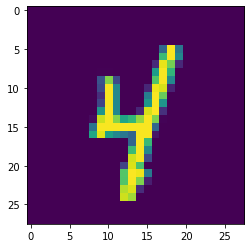

------- 4


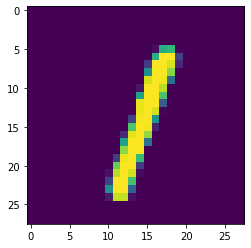

------- 1


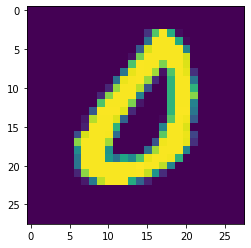

------- 0


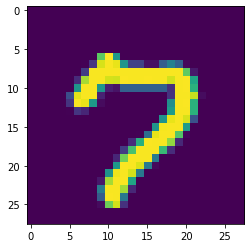

------- 7


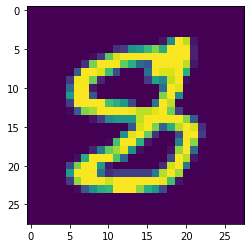

------- 8


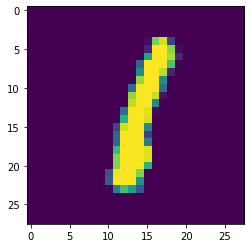

------- 1


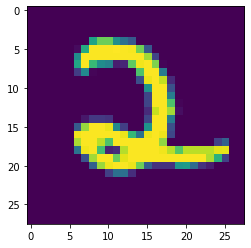

------- 2


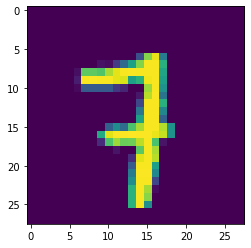

------- 7


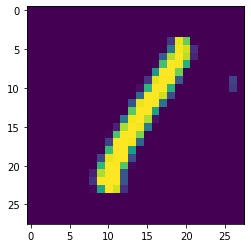

------- 1


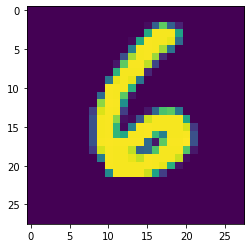

------- 6


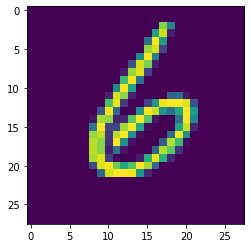

------- 6


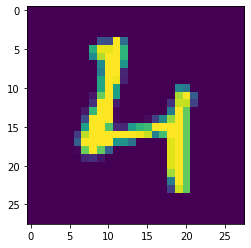

------- 4


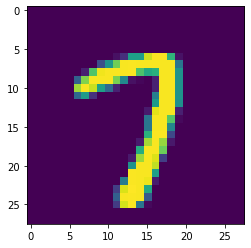

------- 7


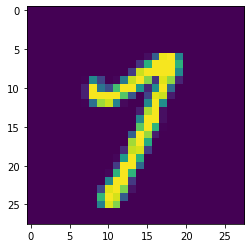

------- 7


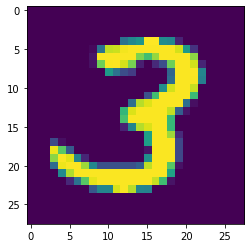

------- 3


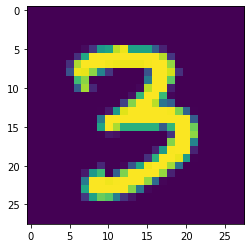

------- 3


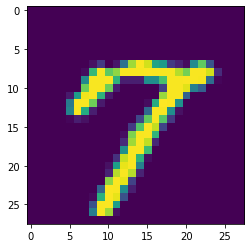

------- 7


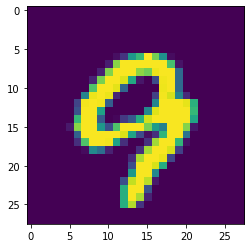

------- 9


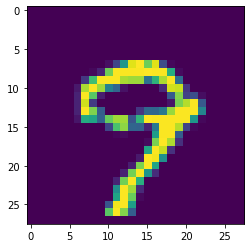

------- 9


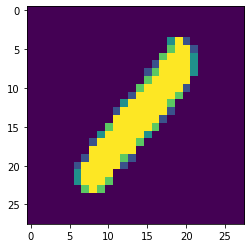

------- 1
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 

In [16]:
model_trained = experiments(dataset_path=None,dataset="mnist",image_size=(32,32),Data_preprocessing="1",Augmentation="0",
                            Shuffling="1",Regularization="0",Models="0",classifier=True,
                            augmentation_list = [random_rotate,random_zoom],augmentation_steps=10,
                            split=True,split_ratio=[0.8,0.2],batch_size=64,epochs=10,shuffling_steps=1,
                 save_train_test_data = False,dropout=0.5)
model = model_trained()